# Large size problems : xesmf regridding issues (structured grids) - Fixes
<a class="anchor" id="introduction"></a>

**Quick Description**<a class="anchor" id="introduction_quick"></a>

This notebook is intended to describe ```MemoryError``` issues encountered with the package xesmf while encapsulating the sparse ```sparse.COO``` matrix of the regridding weights under an ```xarray.DataArray``` structure. Tests were conducted on HPC facilities without applying any type of parallelization (frontend). The xesmf package was installed with conda using the [conda-forge channel](https://github.com/conda-forge/xesmf-feedstock?). The installed version of the conda binaries is [xesmf-0.6.2](https://conda.anaconda.org/conda-forge/noarch/xesmf-0.6.2-pyhd8ed1ab_0.tar.bz2?) but we did the appropriate checks confirming that the latest [conda binaries version xesmf-0.6.3](https://conda.anaconda.org/conda-forge/noarch/xesmf-0.6.3-pyhd8ed1ab_1.tar.bz2?) were not solving the issues documented hereafter. The underlying package versions are therefore the following:

- esmf-8.0.1, esmpy-8.0.1
- xesmf-0.6.2

A **dedicated branch under the github** has been set up within the following [**forked repository**](https://github.com/lemieuxbenedicte/xESMF?) where we **propose fixes and tests** presented in this jupyter-notebook. Please follow the links :
 - to [github branch related to issue9](https://github.com/lemieuxbenedicte/xESMF/tree/master/xesmf/xesmf_fix10?),
 - and to the [github jupyter-notebooks](https://github.com/lemieuxbenedicte/xESMF/tree/master/doc/notebooks/Large_size_problems_Structured_grids_with_mask_FIX10_Issue9_with_xarray_DataArray_backed_by_sparse_COO.ipynb?)
 
The issue documented hereafter is refered as to *Issue9*. It has been observed with *real data* but they are reproduced in this notebook with synthetic grids [prepared with xesmf.util.grid_2d](https://github.com/pangeo-data/xESMF/blob/master/doc/notebooks/Backend.ipynb?).

We propose a basic **fixe** consisting in maintaining the regridding **weights under their sparse representation** as a ```sparce.COO``` matrix.

This document and experiments are twined with another jupyter-notebook intended to describe and propose fixes to
a connected issue (a simple bug) also related to the handling of the regridding weights as a ```sparse.COO``` array and/or an ```xarray.DataArray``` backed by a ```sparse.COO``` array (issues when handling grids with masked data and the writing of the interpolation weights to a netCDF file). This notebook is available [here](Small_size_problems_Structured_grids_with_mask_Issues_1_and_2_with_xarray_DataArray_backed_by_sparse_COO.ipynb?) or on the [github forked repository](https://github.com/lemieuxbenedicte/xESMF/tree/master/doc/notebooks/Small_size_problems_Structured_grids_with_mask_Issues_1_and_2_with_xarray_DataArray_backed_by_sparse_COO.ipynb?). 

**Detailed description**<a class="anchor" id="introduction_detailed"></a>

This notebook is intended to describe ```MemoryError``` issues encountered with the package xesmf while encapsulating the sparse matrix of regridding weights under an ```xarray.DataArray``` structure. 

As far as I can understand, ```xesmf``` is meant to be a wrapper of esmpy/ESMF providing facilities to use the full power of ```xarray``` (as well as ```dask```) objects and methods. And this effort is really appreciated. In this objective, ```xesmf``` tends to make a systematic use of ```xarray.DataArray``` or ```xarray.Dataset``` to encapsulate :

 - either numpy.ndarray or dask.Array (e.g., source and destination grid data),
 - or ```sparse.COO``` objects (regridding weights).

Precisely, ```xesmf``` wraps up the 2D matrix of regridding weights (mapping the source grid data to the destination grid) into an ```xarray.DataArray``` structure. This matrix is a sparse and is represented under the ```sparse.COO``` format and package. There is a pitfall however, knowing that the **```xarray``` package is not currently able to properly encapsulate sparse array object**, such as **```sparse.COO```**. ```xarray``` **fails interpreting the sparse object hidden behind the ```numpy.ndarray``` type** and **reserves Memory for the full size array instead**. This can cause **```MemoryError``` failures** and/or result in the **use of an unecessary large amount of Memory**.

In this notebook, we **describe the MemoryError issue** and **propose fixes** refer as to **FIX10**, hereafter.

The MemoryError issue described here was first experimented with *real data* but we reproduced it with synthetic grids [prepared with xesmf.util.grid_2d](https://github.com/pangeo-data/xESMF/blob/master/doc/notebooks/Backend.ipynb?). Note that apparently, this issue cannot currently be handled using dask chunks :

   - [xesmf v6.0.2 does not currently support horizontal chunks](https://xesmf.readthedocs.io/en/latest/large_problems_on_HPC.html?)
   
   - [see eventually](https://github.com/pangeo-data/xESMF/blob/master/doc/notebooks/Dask.ipynb?) [advising to use the esmpy/ESMF backend for Large size problems](https://xesmf.readthedocs.io/en/latest/large_problems_on_HPC.html?) with a proper MPI/MPICH installation.

The fix **Fix10** is available under the github forked repository into the [github branch related to issue9](https://github.com/lemieuxbenedicte/xESMF/tree/master/xesmf/xesmf_fix10?). 

Again, this document and experiments are twined with another jupyter-notebook intended to describe and propose fixes to issues encountered when the regridding involves source (and destination grids) with masked data (i.e., triggering extrapolation) with a corollary issue when trying to save the sparse matrix of regridding weights to a netCDF file. This notebook is available [here](Small_size_problems_Structured_grids_with_mask_Issues_1_and_2_with_xarray_DataArray_backed_by_sparse_COO.ipynb?) or on the [github forked repository](https://github.com/lemieuxbenedicte/xESMF/tree/master/doc/notebooks/Small_size_problems_Structured_grids_with_mask_Issues_1_and_2_with_xarray_DataArray_backed_by_sparse_COO.ipynb?). Both issues are connected under the hood, to the handling of the regridding weights as a sparse.COO array and/or an xarray.DataArray backed by a sparse.COO array. These fixes are applied in the final fix called FIX10 and therefore are on the github fork as well. 

1. [Introduction](#introduction)
    
   1. [Quick description](#introduction_quick)
   
   2. [Detailed description](#introduction_detailed)
   
1. [Reproducing the MemoryError with the synthetic grids](#RepMemoryError)

   1. [Loading xesmf installed from the conda-forge channel](#LoadOriXESMFConda)
   
   2. [Constructing the unmasked synthetic source and destination grids](#UnmaskedSrcDesrGrids)
   
      - [Setting the grid size and resolution used in this notebook](#AreaExtGridReso)
      
      - [Eventually, source grid set as F-contiguous grids](#FContiguous)
      
      - [Synthetic source grid data](#SourceGridData)
      
      - [Eventually, destination grid set as F-contiguous grids](#DestGridFcontigous)
      
      
   3. [Triggering the MemoryError issue when computing the regridding weights with the xesmf conda-forge package](#ComputeRegriddingWeightWithOriXESMFPckg)<a class="anchor">ExpSettings</a>

      - [MemoryError](#MemoryError)
      
      - [Regridder MemoryError Failure arise when trying to wrap up the sparse.COO weight matrix into an xarray.DataArray structure = Issue9](#MemoryErrorExplanation)
      
      
   4. [Testing fixes to avoid the MemoryError](#TestingFixesToMemoryError)    
   
      1. [Loading xesmf with FIX10 available in Github fork branch](#LoadingGitHubFix10)
      
      2. [Launching the exact same experiment](#ExactSameExpSettings)
      
        - [No MemoryError when computing the regridding weights](#NoMemoryError)
      
        - [Success in regridding the data from source grid](#RegriddingSuccessWithFix10)
      
        - [Source and regridded data : comparison](#RegriddedDataMapWithFix10)
       
      3. [New experiment settings : testing masked data and extrapolation](#NewExpSettingsWithMasks)
      
        - [Adding masks to source](#SrcGridMask) and [destination grids](#DestGridMask)
        
        - [Launching the computation of the weigts](#ConstructingWeightsWthMskData)
        
          - [Success in computing the regridding weights](#MskDataComputeWeightsSuccess)
          
          - [Success in regridding the masked data from source grid](#MskDataRegriddingSuccess)
          
          - [Source and regridded data with mask : comparison](#MskDataRegriddedDataMap)
          
          - [Same experiment without writing file to disk](#MskDataNoFileToDisk)
         
        - [Testing possible issues with several other configurations](#PossibleIssueToFix)
          
          - [Regridding by re-using weights previously calculated](#ReUseWeights)
          
            - [Re-use weights that have been saved to netCDF file and perform regridding](#ReUseWeightsFromFile)
            
            - [Re-use weights from the regrider object and perform regridding](#ReUseWeightsFromRegridderObject)
            
      4. [Testing fixes to avoid the MemoryError with other xesmf regridding methods](#ExpWithSeveralRegriddingMethods)     
          
          - [Conservative](#ConservativeRegridding)
          
          - [Conservative Normed](#ConservativeNormedRegridding)
          
          - [Patch](#PatchRegridding)
       
           
2. [Conclusion](#Conclusion)             


## Loading python packages other than xesmf
<!-- Loading python packages other than xesmf -->

In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
#import xesmf as xe
print('numpy  version {0}'.format(np.__version__))
print('xarray version {0}'.format(xr.__version__))

numpy  version 1.20.2
xarray version 2022.3.0


In [2]:
import scipy
import sparse as sps
print('scipy  version {0}'.format(scipy.__version__))
print('sparse version {0}'.format(sps.__version__))

scipy  version 1.6.2
sparse version 0.3.1


# User settings 

## Please eventually adapt the path to your output directory

In [3]:
dirout="/tmpdir/p22007lb/Regridding_xesmf_tests"
if_olympe=os.path.exists(dirout)
if dirout is None or not os.path.exists(dirout) :
    dirout=os.getcwd()
print(dirout)

/tmpdir/p22007lb/Regridding_xesmf_tests


# Experiments to demonstrate Issue9


# REQUIREMENT WARNING !!!<a class="anchor" id="LoadOriXESMFConda"></a>

## EXPECTED xesmf package is version 6.0.2 from the conda-forge channel

#### To reproduce demonstration, please verify what xesmf package and version will be loaded <a class="anchor" id="xesmf_pckg_check_1"></a> please pay attention to [checks performed here](#xesmf_pckg_check_2)

In [4]:
import xesmf as xe

In [5]:
print('xesmf  : current conda-forge version {0} without fixes to issue9'.format(xe.__version__))

xesmf  : current conda-forge version 0.6.2 without fixes to issue9


# Investigating the xesmf loaded package <a class="anchor" id="xesmf_pckg_check_2"></a>

In [6]:
import sys
print(sys.executable)
print(type(sys.executable))
print(sys.executable.find('.conda/envs'))
if sys.executable.find('.conda/envs')!=-1 :
    if_conda_env=True
else :
    if_conda_env=False

/users/p22007/p22007lb/.conda/envs/mydap-python-tools-3.9.5/bin/python
<class 'str'>
23


In [7]:
import subprocess
import locale
print(locale.getpreferredencoding(do_setlocale=False))
        
def getCondaPackageInfoGuessSysEncoding(myconda_env=None, mypckg='xesmf', if_text_bool=True, listoptions='--show-channel-urls'):
    if myconda_env is None :
        print('@CONDA env Not provided')
        result = subprocess.Popen(['conda', 'list', listoptions], 
                          stdout = subprocess.PIPE, stderr = subprocess.STDOUT,
                          text=if_text_bool)
    else :
        print('@CONDA env provided')
        result = subprocess.Popen(['conda', 'list', '-n', myconda_env, listoptions], 
                        stdout = subprocess.PIPE, stderr = subprocess.STDOUT,
                        text=if_text_bool)
    for x in result.stdout.readlines():
        if x.find(mypckg)!=-1 :
            return x
        else :
            if_not_found=True
    if if_not_found :
        if not (myconda_env is None ) and (isinstance(myconda_env,(str,))) :
            return 'Package '+mypckg+' not found in conda env '+myconda_env
        else :
            return 'Package '+mypckg+' not found'
#    return [x for x in result.stdout.readlines() if x.find('xesmf')!=-1]

UTF-8


### In the case of a conda environment searching provide info on the xesmf package build 

In [8]:
if if_conda_env :
    #myconda_env='mydap-python-tools-3.9.5'
    myconda_env=None
    mypckg='xesmf'
    if_text_bool=True
    listoptions='--explicit'
    output = getCondaPackageInfoGuessSysEncoding(myconda_env=myconda_env, mypckg=mypckg, if_text_bool=if_text_bool, listoptions=listoptions)
    print(output)
if if_conda_env :
    #myconda_env='mydap-python-tools-3.9.5'
    myconda_env=None
    mypckg='xesmf'
    if_text_bool=True   
    listoptions='--show-channel-urls'
    #listoptions='--explicit'
    output = getCondaPackageInfoGuessSysEncoding(myconda_env=myconda_env, mypckg=mypckg, if_text_bool=if_text_bool, listoptions=listoptions)
    print(output)
    if_test_conda_package = (output.find('0.6.2')!=-1) and (output.find('conda-forge')!=-1)
    conda_with_xesmf_version_0_6_2_with_issues = [ True if if_test_conda_package else False]
    if conda_with_xesmf_version_0_6_2_with_issues :
        print('The xesmf package version 0.6.2 is from the conda-forge')
        print('Test will now go on')
    else :
        print('The xesmf package version is not 0.6.2 or not from the conda-forge')
        #del xesmf

@CONDA env Not provided
https://conda.anaconda.org/conda-forge/noarch/xesmf-0.6.2-pyhd8ed1ab_0.tar.bz2

@CONDA env Not provided
xesmf                     0.6.2              pyhd8ed1ab_0    conda-forge

The xesmf package version 0.6.2 is from the conda-forge
Test will now go on


In [9]:
from importlib.metadata import metadata

In [10]:
print(metadata('xesmf')['Version'])
print(metadata('xesmf')['Home-page'])
if_test_package = ( metadata('xesmf')['Version'].find('0.6.2')!=-1 )
#and (metadata('xesmf')['Home-page'].find('https://github.com/pangeo-data/xESMF')!==0)
package_xesmf_version_0_6_2_with_issues = [ True if if_test_package else False]
if package_xesmf_version_0_6_2_with_issues :
    print('The xesmf package version is 0.6.2 is from '+ metadata('xesmf')['Home-page'])
    print('Test will now go on')
else :
    mygitrep='https://github.com/lemieuxbenedicte/xESMF'
    print('Assuming you haved cloned gitub xesmf forked repository '+mygitrep)
    try :
        del xe
        import xesmf.xesmf_v0_6_2_github as xe
    except :
        print('WARNING ! THE XESMF LOADED PACKAGE MAY NOT SHOW THE ISSUES (UNIDENTIFIED VERSION, REPOSITORY)')
        print('The xesmf package version is not 0.6.2')

0.6.2
https://github.com/pangeo-data/xESMF
The xesmf package version is 0.6.2 is from https://github.com/pangeo-data/xESMF
Test will now go on


In [11]:
# OLYMPE ONLY

In [34]:
print(if_olympe)
if if_olympe :
    del xe
    import xesmf.xesmf_v0_6_2_github as xe

True


# Reproducing the ```MemoryError``` with ad hoc synthetic data <a class="anchor" id="RepMemoryError"></a>
<!-- Reproducing-the-```-MemoryError```- with-ad-hoc-synthetic-data -->

The demonstration is conducted with data prepared with xesmf.util.grid_2d [as explained in the doc](https://github.com/pangeo-data/xESMF/blob/master/doc/notebooks/Backend.ipynb?).

The issue was initially raised using **real data** where source and destination grids were provided as ```xarray.Dataset``` and defined as 2D-arrays of longitude, latitude and using a mask (the grid and data arrays were eventually modified to be C-contiguous).

In the following, we reproduce the ```MemoryError``` issue discussed in the introduction (TODO link) using the synthetic grids with the standard ```xesmf``` installed from the ```conda-forge channel``` using ```conda```. 

Since the current conda xesmf version does not include the fixes enabling to handle masked grids with extrapolation methods (see [fixes to Issue1 and Issue2 describe in the twin jupyter-notebook](Small_size_problems_Structured_grids_with_mask_Issues_1_and_2_with_xarray_DataArray_backed_by_sparse_COO.ipynb?), we conduct the following demonstration over unmasked synthetic grids with regridding methods that exclude any extrapolation. We a set reasonably large synthetic grids (TODO see in Gigabytes) :

 - the xarray.Dataset ```ds_in``` contains source grid and data,
 - the xarray.Dataset ```ds_out``` is the destination grid.

## Constructing unmasked source and destination grids with [xesmf.util.grid_2d](https://github.com/pangeo-data/xESMF/blob/master/doc/notebooks/Backend.ipynb?)<a class="anchor" id="UnmaskedSrcDesrGrids"></a>

### Defining the area extension and grid resolution for the full notebook<a class="anchor" id="AreaExtGridReso"></a>

In [13]:
# Grid extension
lonmin, lonmax =  -10., 30. 
latmin, latmax =  35, 45.

In [14]:
# Resolution of source Grid
lonreso_in=0.04
latreso_in=0.03
#  Resolution of destination Grid
lonreso_out=0.06
latreso_out=0.02

In [15]:
ds_in  = xe.util.grid_2d(lonmin, lonmax, lonreso_in,  latmin, latmax, latreso_in) 
ds_out = xe.util.grid_2d(lonmin, lonmax, lonreso_out, latmin, latmax, latreso_out)

In [16]:
print('Source grid size for the only longitude/latitude DataArray')
print("- lon size nbytes in MB:", ds_in.lon.nbytes / (1024*1024))
print("- lat size nbytes in MB:", ds_in.lat.nbytes / (1024*1024))
print("- lon_b size nbytes in MB:", ds_in.lon_b.nbytes / (1024*1024))
print("- lat_b size nbytes in MB:", ds_in.lat_b.nbytes / (1024*1024))

Source grid size for the only longitude/latitude DataArray
- lon size nbytes in MB: 2.5482177734375
- lat size nbytes in MB: 2.5482177734375
- lon_b size nbytes in MB: 2.5584030151367188
- lat_b size nbytes in MB: 2.5584030151367188


In [17]:
print('Destination grid size for the only longitude/latitude DataArray')
print("- lon size nbytes in MB:", ds_out.lon.nbytes / (1024*1024))
print("- lat size nbytes in MB:", ds_out.lat.nbytes / (1024*1024))
print("- lon_b size nbytes in MB:", ds_out.lon_b.nbytes / (1024*1024))
print("- lat_b size nbytes in MB:", ds_out.lat_b.nbytes / (1024*1024))

Destination grid size for the only longitude/latitude DataArray
- lon size nbytes in MB: 2.5494918823242188
- lat size nbytes in MB: 2.5494918823242188
- lon_b size nbytes in MB: 2.55841064453125
- lat_b size nbytes in MB: 2.55841064453125


### Eventually, source grid and data transformed to be F-contiguous<a class="anchor" id="FContiguous"></a>

In [18]:
print(ds_in["lon_b"].data.shape)
ds_in["lon_b"].data.flags

(335, 1001)


  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [19]:
ds_in["lon_b"].data.T.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [20]:
ds_in["lon_b"].values=ds_in["lon_b"].values.copy(order='F')
ds_in["lat_b"].values=ds_in["lat_b"].values.copy(order='F')
ds_in["lon"].values=ds_in["lon"].values.copy(order='F')
ds_in["lat"].values=ds_in["lat"].values.copy(order='F')

In [21]:
print(ds_in["lon_b"].data.shape)
ds_in["lon_b"].data.flags

(335, 1001)


  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [22]:
ds_in["lon"].data.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

### Construct the 2D and 4D source data + check C-contiguity<a class="anchor" id="SourceGridData"></a>

In [23]:
if_4D_data=False
ds_in["data2D"] = xe.data.wave_smooth(ds_in["lon"], ds_in["lat"])
if if_4D_data :
    #ntimes,nlevs=11,51
    ntimes,nlevs=2,3
    ds_in.coords["time"] = np.arange(1, ntimes)
    ds_in.coords["lev"] = np.arange(1, nlevs)
    ds_in["data4D"] = ds_in["time"] * ds_in["lev"] * ds_in["data2D"]

In [24]:
print('Source grid size for the data2D DataArray')
print("- lon size nbytes in MB:", ds_in.data2D.nbytes / (1024*1024))

Source grid size for the data2D DataArray
- lon size nbytes in MB: 2.5482177734375


In [25]:
ds_in["data2D"].values.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [26]:
ds_in["data2D"].values=ds_in["data2D"].values.copy(order='F')

In [27]:
ds_in["data2D"].values.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

### Destination grid eventually organized as F-contiguous<a class="anchor" id="DestGridFcontigous"></a>

In [28]:
ds_out["lon_b"].data.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [29]:
ds_out["lon_b"].values=ds_out["lon_b"].values.copy(order='F')
ds_out["lat_b"].values=ds_out["lat_b"].values.copy(order='F')

In [30]:
ds_out["lon_b"].data.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

## Triggering the MemoryError issue when computing the regridding weights with the xesmf conda-forge package<a class="anchor" id="ComputeRegriddingWeightWithOriXESMFPckg"></a>
<!-- Triggering-the-computation-of-the-interpolation-weights -->

We trigger the computation of the weights using the frontend.py ```BaseRegridder class``` to construct the ```reggrider``` object (i.d., method ```__init__```).

We use the following arguments ```method='bilinear'```, ```extrap_method=None``` (optional since we have unmasked grids). To compute the weights and save them to disk we further set ```reuse_weights=False```, ```weights=None``` and also we provide a valid ```filename``` in order to save the interpolation weights to a netCDF file.

#### Defining a file name for saving the interpolation weights to a netCDF file

In [31]:
ny_src,nx_src = ds_in["data2D"].shape[0],ds_in["data2D"].shape[1]
ny_tgt_red,nx_tgt_red = ds_out['lon'].shape[0],ds_out['lon'].shape[1]
method='bilinear'
pattern='{0}_{1}x{2}_{3}x{4}'.format(
            method,
            ny_src,
            nx_src,
            ny_tgt_red,
            nx_tgt_red)
filout_wghts_='weights_xesmf_conda_memissue_'+pattern+'.nc'
print(filout_wghts_)
filout_wghts=os.path.join(dirout,filout_wghts_)
print('Path to {0}'.format(filout_wghts))

weights_xesmf_conda_memissue_bilinear_334x1000_501x667.nc
Path to /tmpdir/p22007lb/Regridding_xesmf_tests/weights_xesmf_conda_memissue_bilinear_334x1000_501x667.nc


## MemoryError with the conda-forge xesmf package<a class="anchor" id="MemoryError"></a>

<!--  Regridder-weights-Failure-with-the-xesmf-package-having-only-fixes-to-issue1-and-2 -->

In [32]:
method='bilinear'
extrap_method=None
reuse_weights=False
weights=None

In [33]:
reggrider = xe.Regridder(ds_in,ds_out, method=method,extrap_method=extrap_method,reuse_weights=reuse_weights,weights=weights,filename=filout_wghts)

/users/p22007/p22007lb/.conda/envs/mydap-python-tools-3.9.5/lib/python3.9/site-packages/xesmf/xesmf_v0_6_2_github/backend.py:38: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')


MemoryError: Unable to allocate 832. GiB for an array with shape (334167, 334000) and data type float64

## Regridder Failure arise when trying to wrap up the sparse.COO weight matrix into an xarray.DataArray and raises a MemoryError<a class="anchor" id="MemoryErrorExplanation"></a>

<!-- Regridder-Failure-arise-in-the-function-which-replaces-zeros-by-NaNs-for-unmapped-grid-points -->

### You should see the following ERROR

```MemoryError: Unable to allocate 832. GiB for an array with shape (334167, 334000) and data type float64```

### IF YOU DO NOT HAVE THIS ERROR, this is PROBABLY BECAUSE YOU LOADED AN UPGRADED xesmf VERSION

[**PLEASE CHECK YOUR XESMF VERSION WHICH SHOULD BE 6.0.2 FROM THE CONDA-FORGE CHANNEL OR THE PANGEO GITHUB REPOSITORY**](#xesmf_pckg_check_2)

**Let's call this issue Issue9**

**It occurs occurs in xesmf/smm.py line 100 in function ```_parse_coords_and_values```:**

```python
return xr.DataArray(sps.COO(crds, s, (n_out, n_in)), dims=('out_dim', 'in_dim'), name='weights')
```

The variable ```sps.COO(crds, s, (n_out, n_in)``` holds the regridding weights calculated by the ```esmpy/ESMF``` backend. The regridding involves a 2D matrix of weights which maps the source grid on to the destination grid. This weight matrix is a sparse matrix and benefits to be represented as such to save Memory (only non-null elements saved in memory). 

The ```MemoryError``` occuring line 100 within smm.py is due to : (i) ```xarray``` not being able to handle the sparse object correctly, and (ii) ```xesmf``` package tending to wrap up numpy arrays and/or sparse or scipy sparse matrix into ```xarray.DataArray```. 

At line 100 in smm.py, the variable ```sps.COO(crds, s, (n_out, n_in)``` is a ```sparse.COO``` object (i.e., multi-dimensional sparse array) and ```xarray``` attemps to wrap it up into an ```xarray.DataArray```. Unfortunately, **```xarray``` does not currently understand the ```sparse.COO``` object and loads the full size weight matrix as a regular ```numpy.ndarray``` which ends up consumimg a lot of Memory**.
     
I introduced a series of possible fixes to prevent this ```MemoryError``` in ```xesmf/ssm.py``` and ```xesmf/frontend.py``` based at the root on the **handling of the ```MemoryError``` exception** occuring each time ```xesmf``` attempts **to wrap up the weights under an ``xarray.DatArray`` object**.
The main idea is **keep the sparse matrix of weigts under its ```sparse.COO``` representation format** :

```python
try :
    output=xr.DataArray(sps.COO(crds, s, (n_out, n_in)), dims=('out_dim', 'in_dim'), coords={'out_dim','in_dim'} , name='weights')
except MemoryError :
    output=sps.COO(crds, s, (n_out, n_in))
```

# Testing fixes to the conda-forge xesmf package in order to avoid the MemoryError<a class="anchor" id="TestingFixesToMemoryError"></a>

<!-- Testing-the-fixes-to-the-conda-forge-xesmf-package-in-order-to-avoid-the-MemoryError -->

The following experiments show that FIX10 to issue9 solves the xesmf Regridder Failure that is raising the **```MemoryError``` exception each time xesmf attempt to wrap up the ```sparse.COO``` weight matrix into an ```xarray.DataArray``` structure**  

## Loading the modified xesmf package with fix FIX10<a class="anchor" id="LoadingGitHubFix10"></a>

**Delete the original loaded xesmf module from the conda-forge channel and load the module having FIX10**

In [35]:
del xe

In [36]:
import xesmf.xesmf_fix10 as xe

# Experiment settings are exactly identical to the previous test with the original xesmf conda package<a class="anchor" id="ExactSameExpSettings"></a>

## Exact same source and destination grid
   
The demonstration is again conducted with the synthetic data already prepared with xesmf.util.grid_2d [as explained in the doc](https://github.com/pangeo-data/xESMF/blob/master/doc/notebooks/Backend.ipynb?).

## Exact same regridding options

We use the following arguments ```method='bilinear'```, ```extrap_method=None``` (optional since we have unmasked grids). To compute the weights and save them to disk we further set ```reuse_weights=False```, ```weights=None``` and also we provide a valid ```filename``` in order to save the interpolation weights to a netCDF file.

In [37]:
print('- method={0}'.format(method))
print('- extrap_method={0}'.format(str(extrap_method)))
print('- reuse_weights={0}'.format(str(reuse_weights)))
print('- weights={0}'.format(str(weights)))

- method=bilinear
- extrap_method=None
- reuse_weights=False
- weights=None


#### Defining a new file name for saving the interpolation weights to a netCDF file

In [38]:
ny_src,nx_src = ds_in["data2D"].shape[0],ds_in["data2D"].shape[1]
ny_tgt_red,nx_tgt_red = ds_out['lon'].shape[0],ds_out['lon'].shape[1]
method='bilinear'
pattern='{0}_{1}x{2}_{3}x{4}'.format(
            method,
            ny_src,
            nx_src,
            ny_tgt_red,
            nx_tgt_red)
filout_wghts_='weights_fix9_to_xesmf_conda_memissue_'+pattern+'.nc'
print(filout_wghts_)
filout_wghts=os.path.join(dirout,filout_wghts_)
print('Path to {0}'.format(filout_wghts))

weights_fix9_to_xesmf_conda_memissue_bilinear_334x1000_501x667.nc
Path to /tmpdir/p22007lb/Regridding_xesmf_tests/weights_fix9_to_xesmf_conda_memissue_bilinear_334x1000_501x667.nc


### Regridder construction with fix F10 to issue9 - SUCCESS<a class="anchor" id="NoMemoryError"></a>

 **Exact regridding options and same source and destination grid as in the xesmf conda pckg raising ```MemoryError```**

Options :```reuse_weights=False```, ```weights=None``` and a valid ```filename```

In [39]:
reggrider = xe.Regridder(ds_in,ds_out, method=method,extrap_method=extrap_method,reuse_weights=reuse_weights,weights=weights,filename=filout_wghts)

Method IS = bilinear
NO BOUNDS NEEDED
@RegridderBase class instanciation : COMPUTE WEIGHTS


/users/p22007/p22007lb/.conda/envs/mydap-python-tools-3.9.5/lib/python3.9/site-packages/xesmf/xesmf_fix10/backend.py:38: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')


@RegridderBase class instanciation : convert WEIGHTS to sparse.COO matrix + try to wrap it into an xr.Dataset
@READ_WEIGHTS FUNCTION in smm.py
 => call _parse_coords_and_values SPARSE COORDS AND VALUE
<class 'dict'>
@_PARSE_COORDS_AND_VALUES FUNCTION in smm.py
@_parse_coords_and_values : FUNCTION ARG as dict
  => indata weights as dict : classical backend format for just calculated weights
     converting backend format to sparse.COO format
    xarray.DataArray backed by the sparse.COO matrix of weights
    does not understand the sparse object and is hosting in turn
    the full matrix size => to avoid failure keep weights as a sparse.COO object
 @OUT READ_WEIGHTS FUNCTION in smm.py
@to_netcdf : self.weights is a sps.COO matrix


### Regridding source data with fix F10 to issue9  - SUCCESS<a class="anchor" id="RegriddingSuccessWithFix10"></a>

This step performs the regridding of the source data using the previously computed ```regridder``` object and associated interpolation weights.

  **Exact regridding options and same source and destination grid as in the xesmf conda pckg raising ```MemoryError```**

In [40]:
ds_regridded  = ds_out.copy( deep=True )
ds_regridded["data2D"]=reggrider(ds_in["data2D"])

@Class Regridder.__call__ method : Memory Issue Handling
<COO: shape=(334167, 334000), dtype=float64, nnz=1329336, sorted=False, duplicates=True>
@Class Regridder.__call__ method : Memory Issue Handling
 weights has sparse.COO format
@@@ regrid_dataarray from sparse.coo weights matrix
@@@Numpy.ndarray : regrid_array


/users/p22007/p22007lb/.conda/envs/mydap-python-tools-3.9.5/lib/python3.9/site-packages/xesmf/xesmf_fix10/smm.py:172: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [41]:
print('Original  data with size of the source      grid is {0:d}x{1:d}'.format(ds_in["data2D"].shape[0],ds_in["data2D"].shape[1]))
print('Regridded data with size of the destination grid is {0:d}x{1:d}'.format(ds_regridded["data2D"].shape[0],ds_regridded["data2D"].shape[1]))

Original  data with size of the source      grid is 334x1000
Regridded data with size of the destination grid is 501x667


### Maps of regridded source data with fix FIX10 - SUCCESS<a class="anchor" id="RegriddedDataMapWithFix10"></a>


   **Exact regridding options and same source and destination grid as in the xesmf conda pckg raising ```MemoryError```**

**Source data**

[Text(0.5, 1.0, 'Data on the original grid (no mask)')]

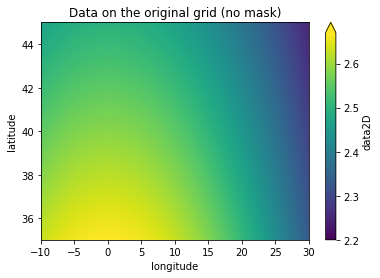

In [42]:
ds_in["data2D"].plot(x='lon',y='lat',vmin=2.2, vmax=2.67)
ax=plt.gca()
ax.set(title="Data on the original grid (no mask)")

**Regridded data**

[Text(0.5, 1.0, 'Data interpolated on the destination grid (no mask)')]

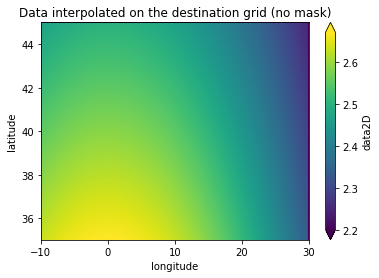

In [43]:
ds_regridded["data2D"].plot(x='lon',y='lat', vmin=2.2, vmax=2.67)
ax=plt.gca()
ax.set(title="Data interpolated on the destination grid (no mask)")


# New experiment settings : adding masks to the source and destination grids<a class="anchor" id="NewExpSettingsWithMasks"></a> 


Since fix FIX10 includes a series of fixes among which [FIX1 and FIX2 related to the handling of masked grids with and extrapolation context](Small_size_problems_Structured_grids_with_mask_Issues_1_and_2_with_xarray_DataArray_backed_by_sparse_COO.ipynb?), we now add masks to the synthetic source and destination grids. Again :

 - the xarray.Dataset ```ds_in``` contains source grid and data,
 - the xarray.Dataset ```ds_out``` is the destination grid.
 
**Note : the two grids have unchanged size as for the experiment raising the MemoryError**

**Cleaning**

In [44]:
del reggrider, ds_regridded

## Creating the source grid mask<a class="anchor" id="SrcGridMask"></a>

In [45]:
ds_in['mask']=xr.ones_like(ds_in['lon'])
ds_in['mask'].name='mask'
print(ds_in['mask'].data.shape)
ds_in['mask'].data.flags

(334, 1000)


  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [46]:
if_complicated_mask=True
if not if_complicated_mask :
    ds_in['mask'].data[0:24,:]=0
    ds_in['mask'].data[:,0:60]=0
else :
# Artificial masked points
    import random
    ii_max_extent=int(ds_in['mask'].data.shape[0]/6.)
    jj_max_extent=int(ds_in['mask'].data.shape[1]/6.)
    for jj in range(ds_in['mask'].data.shape[1]) :
        ds_in['mask'].data[0:random.randint(0, ii_max_extent),jj]=0
    for ii in range(ds_in['mask'].data.shape[0]) :
        ds_in['mask'].data[ii,0:random.randint(0, jj_max_extent)]=0

## Creating the destination grid mask <a class="anchor" id="DestGridMask"></a>

In [47]:
ds_out['mask']=xr.ones_like(ds_out['lat'])
ds_out['mask'].name='mask'
print(ds_out['mask'].data.shape)

(501, 667)


In [48]:
if_complicated_mask=True
if not if_complicated_mask :
    ds_out['mask'].data[0:18,:]=0
    ds_out['mask'].data[:,0:39]=0
else :
    # Artificial masked points
    import random
    ii_max_extent=int(ds_out['mask'].data.shape[0]/6.)
    jj_max_extent=int(ds_out['mask'].data.shape[1]/6.)
    for jj in range(ds_out['mask'].data.shape[1]) :
        ds_out['mask'].data[0:random.randint(0, ii_max_extent),jj]=0
    for ii in range(ds_out['mask'].data.shape[0]) :
        ds_out['mask'].data[ii,0:random.randint(0, jj_max_extent)]=0

## Construction of the regridding weights with fixes Fix10 to issue9<a class="anchor" id="ConstructingWeightsWthMskData"></a>

#### Regridding ```method = bilinear ```

We trigger the computation of the weights using the following options ```method='bilinear'```, ```extrap_method=None``` (optional since we have unmasked grids). To compute the weights and save them to disk we further set ```reuse_weights=False```, ```weights=None``` and also we provide a valid ```filename``` in order to save the interpolation weights to a netCDF file.

#### Regridding Options

In [49]:
method='bilinear'
extrap_method='nearest_s2d'
reuse_weights=False
weights=None

#### Defining a file name for saving the interpolation weights to a netCDF file

We provide a valid ```filename``` in order to save the interpolation weights to a netCDF file.

In [50]:
ny_src,nx_src = ds_in["data2D"].shape[0],ds_in["data2D"].shape[1]
ny_tgt_red,nx_tgt_red = ds_out['lon'].shape[0],ds_out['lon'].shape[1]
method="bilinear"
pattern='{0}_{1}x{2}_{3}x{4}'.format(
            method,
            ny_src,
            nx_src,
            ny_tgt_red,
            nx_tgt_red)
filout_wghts_='using_issue9_github_fix10_weights_'+pattern+'.nc'
filout_wghts=os.path.join(dirout,filout_wghts_)
print('Path to {0}'.format(filout_wghts))

Path to /tmpdir/p22007lb/Regridding_xesmf_tests/using_issue9_github_fix10_weights_bilinear_334x1000_501x667.nc


In [51]:
print('Regridding Method = {0}'.format(method))

Regridding Method = bilinear


### Regridder construction with fix F10 to issue9 - SUCCESS<a class="anchor" id="MskDataComputeWeightsSuccess"></a>
   
The computation of the interpolation weights occurs when constructing the the ```reggrider``` object  using the instanciation method ```__init__``` of the ```BaseRegridder class``` (frontend.py) arguments 

**```Regridder``` option "saving weights to netCDF file"**

Options :```reuse_weights=False```, ```weights=None``` and a valid ```filename```

In [52]:
reggrider = xe.Regridder(ds_in,ds_out, method=method,extrap_method='nearest_s2d',weights=None,filename=filout_wghts)

Method IS = bilinear
NO BOUNDS NEEDED
@RegridderBase class instanciation : COMPUTE WEIGHTS
@RegridderBase class instanciation : convert WEIGHTS to sparse.COO matrix + try to wrap it into an xr.Dataset
@READ_WEIGHTS FUNCTION in smm.py
 => call _parse_coords_and_values SPARSE COORDS AND VALUE
<class 'dict'>
@_PARSE_COORDS_AND_VALUES FUNCTION in smm.py
@_parse_coords_and_values : FUNCTION ARG as dict
  => indata weights as dict : classical backend format for just calculated weights
     converting backend format to sparse.COO format
    xarray.DataArray backed by the sparse.COO matrix of weights
    does not understand the sparse object and is hosting in turn
    the full matrix size => to avoid failure keep weights as a sparse.COO object
 @OUT READ_WEIGHTS FUNCTION in smm.py
@RegridderBase class instanciation : handle unmapped data due to grid masks
@add_nans_to_weights function in smm.py
@to_netcdf : self.weights is a sps.COO matrix


#### Interpolaton weights object

The regridder object ```regridder``` constructed from  the ```BasicRegridder Class``` has the weights attribute ```reggrider.weights``` where are stored the interpolation weights. The ```reggrider.weights``` type is a sparse ```sparse.COO``` array representing the 2D interpolation weight matrix.

Note to put elsewhere with the demonstration of the MemoryError issue: xarray cannot wrap up sparse.COO matrix without expending them to their full dense size and trigger a MemoryError

In [53]:
reggrider.weights

<COO: shape=(334167, 334000), dtype=float64, nnz=1099428, sorted=False, duplicates=True>

### Regridding source data with fix FIX10 to issue9  - SUCCESS <a class="anchor" id="MskDataRegriddingSuccess"></a>

This step performs the regridding of the source data using the previously computed ```regridder``` object and associated interpolation weights.

   **```Regridder``` option "saving weights to netCDF file"**

In [54]:
ds_regridded  = ds_out.copy( deep=True )
ds_regridded["data2D"]=reggrider(ds_in["data2D"])

@Class Regridder.__call__ method : Memory Issue Handling
<COO: shape=(334167, 334000), dtype=float64, nnz=1099428, sorted=False, duplicates=True>
@Class Regridder.__call__ method : Memory Issue Handling
 weights has sparse.COO format
@@@ regrid_dataarray from sparse.coo weights matrix
@@@Numpy.ndarray : regrid_array


In [55]:
print('Original  data with size of the source      grid is {0:d}x{1:d}'.format(ds_in["data2D"].shape[0],ds_in["data2D"].shape[1]))
print('Regridded data with size of the destination grid is {0:d}x{1:d}'.format(ds_regridded["data2D"].shape[0],ds_regridded["data2D"].shape[1]))

Original  data with size of the source      grid is 334x1000
Regridded data with size of the destination grid is 501x667


### Maps of regridded source data with FIX10 to issue9 - SUCCESS 
<a class="anchor" id="MskDataRegriddedDataMap"></a>

   **```Regridder``` option "saving weights to netCDF file"**

**Source data**

[Text(0.5, 1.0, 'Data on the original grid (with mask)')]

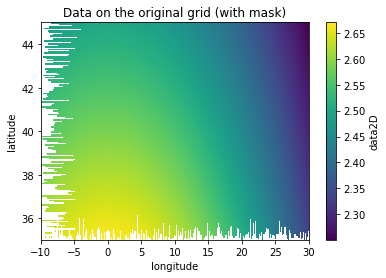

In [56]:
ds_in["data2D"].where(ds_in["mask"]==1).plot(x='lon',y='lat')
ax=plt.gca()
ax.set(title="Data on the original grid (with mask)")

**Regridded data**

[Text(0.5, 1.0, 'Data interpolated on the destination grid (with mask)')]

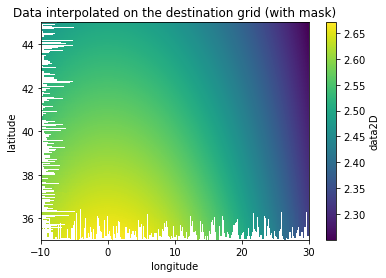

In [57]:
ds_regridded["data2D"].plot(x='lon',y='lat')
ax=plt.gca()
ax.set(title="Data interpolated on the destination grid (with mask)")

### Regridder construction with FIX10 to issue9 
<a class="anchor" id="MskDataNoFileToDisk"></a>

  **```Regridder``` option "no weights saved to netCDF file"**

In [58]:
print('Regridding Method = {0}'.format(method))

Regridding Method = bilinear


In [59]:
reggrider_nowrite = xe.Regridder(ds_in,ds_out, method=method,extrap_method='nearest_s2d',weights=None,filename=None)

Method IS = bilinear
NO BOUNDS NEEDED
@RegridderBase class instanciation : COMPUTE WEIGHTS


/users/p22007/p22007lb/.conda/envs/mydap-python-tools-3.9.5/lib/python3.9/site-packages/xesmf/xesmf_fix10/backend.py:38: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')


@RegridderBase class instanciation : convert WEIGHTS to sparse.COO matrix + try to wrap it into an xr.Dataset
@READ_WEIGHTS FUNCTION in smm.py
 => call _parse_coords_and_values SPARSE COORDS AND VALUE
<class 'dict'>
@_PARSE_COORDS_AND_VALUES FUNCTION in smm.py
@_parse_coords_and_values : FUNCTION ARG as dict
  => indata weights as dict : classical backend format for just calculated weights
     converting backend format to sparse.COO format
    xarray.DataArray backed by the sparse.COO matrix of weights
    does not understand the sparse object and is hosting in turn
    the full matrix size => to avoid failure keep weights as a sparse.COO object
 @OUT READ_WEIGHTS FUNCTION in smm.py
@RegridderBase class instanciation : handle unmapped data due to grid masks
@add_nans_to_weights function in smm.py


### Regridding source data with fix F10 to issue9  - SUCCESS

   **```Regridder``` option "no weights saved to netCDF file"**

In [60]:
ds_regridded  = ds_out.copy( deep=True )
ds_regridded["data2D"]=reggrider_nowrite(ds_in["data2D"])

@Class Regridder.__call__ method : Memory Issue Handling
<COO: shape=(334167, 334000), dtype=float64, nnz=1099428, sorted=False, duplicates=True>
@Class Regridder.__call__ method : Memory Issue Handling
 weights has sparse.COO format
@@@ regrid_dataarray from sparse.coo weights matrix
@@@Numpy.ndarray : regrid_array


/users/p22007/p22007lb/.conda/envs/mydap-python-tools-3.9.5/lib/python3.9/site-packages/xesmf/xesmf_fix10/smm.py:172: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [61]:
print('Original  data with size of the source      grid is {0:d}x{1:d}'.format(ds_in["data2D"].shape[0],ds_in["data2D"].shape[1]))
print('Regridded data with size of the destination grid is {0:d}x{1:d}'.format(ds_regridded["data2D"].shape[0],ds_regridded["data2D"].shape[1]))

Original  data with size of the source      grid is 334x1000
Regridded data with size of the destination grid is 501x667


### Maps of regridded source data with fix FIX10 to issue9 - SUCCESS

  **```Regridder``` option "no weights saved to netCDF file"**

**Source data**

[Text(0.5, 1.0, 'Data on the original grid (with mask)')]

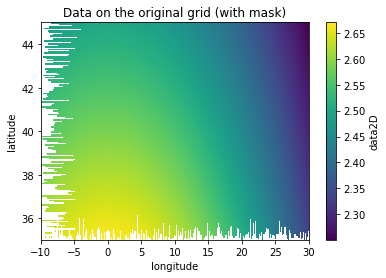

In [62]:
ds_in["data2D"].where(ds_in["mask"]==1).plot(x='lon',y='lat')
ax=plt.gca()
ax.set(title="Data on the original grid (with mask)")

**Regridded data**

[Text(0.5, 1.0, 'Data interpolated on the destination grid (with mask)')]

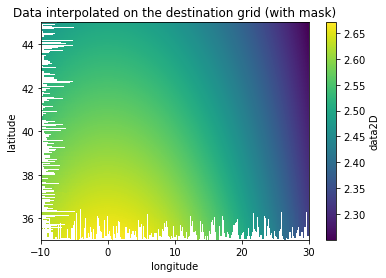

In [63]:
ds_regridded["data2D"].plot(x='lon',y='lat')
ax=plt.gca()
ax.set(title="Data interpolated on the destination grid (with mask)")

### Cleaning tests without netCDF

In [64]:
del reggrider_nowrite
del ds_regridded

# Testing possible hidden issues with fixes FIX10 <a class="anchor" id="PossibleIssueToFix"></a>

## Regridding the source grid data by re-using the saved interpolation weights<a class="anchor" id="ReUseWeights"></a>

**1.  Re-load weights previously saved to netCDF file**

**2.  Apply the weights of the ```regridder``` in memory**

### The netCDF file with weights is saved here

In [65]:
print(filout_wghts)

/tmpdir/p22007lb/Regridding_xesmf_tests/using_issue9_github_fix10_weights_bilinear_334x1000_501x667.nc


### The regridding weights have been saved

The regridder object ```regridder``` of type ```BasicRegridder Class``` has the attribute ```regridder.weights``` holding in memory the interpolation weights previously calculated. Weights are stored under a ```sparse.COO``` object.

In [66]:
reggrider.weights

<COO: shape=(334167, 334000), dtype=float64, nnz=1099428, sorted=True, duplicates=False>

## Regridder construction with weights from netCDF file + FIX10 - SUCCESS <a class="anchor" id="ReUseWeightsFromFile"></a>
          
Options :```reuse_weights=True```, ```weights=None``` and a valid ```filename```

In [67]:
reggrider_reread = xe.Regridder(ds_in,ds_out, method=method,extrap_method='nearest_s2d',reuse_weights=True,weights=None,filename=filout_wghts)

Method IS = bilinear
NO BOUNDS NEEDED
@RegridderBase class instanciation : REUSING WEIGHTS
@RegridderBase class instanciation : convert WEIGHTS to sparse.COO matrix + try to wrap it into an xr.Dataset
@READ_WEIGHTS FUNCTION in smm.py
 => call _parse_coords_and_values SPARSE COORDS AND VALUE
<class 'str'>
@_PARSE_COORDS_AND_VALUES FUNCTION in smm.py
@_parse_coords_and_values : FUNCTION ARG AS str, Path, xr.Dataset
 => indata weights as Path, str : reading indata into xr.Dataset as ds_w
['n_s']
 => expected fields col, row and s
    xarray.DataArray backed by the sparse.COO matrix of weights
    does not understand the sparse object and is hosting in turn
    the full matrix size => to avoid failure keep weights as a sparse.COO object
 @OUT READ_WEIGHTS FUNCTION in smm.py
@RegridderBase class instanciation : handle unmapped data due to grid masks
@add_nans_to_weights function in smm.py


/users/p22007/p22007lb/.conda/envs/mydap-python-tools-3.9.5/lib/python3.9/site-packages/xesmf/xesmf_fix10/backend.py:38: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')


#### Note that we have a new Regrider object with weights as  ```reggrider_reread.weights```

In [68]:
reggrider_reread.weights

<COO: shape=(334167, 334000), dtype=float64, nnz=1099428, sorted=False, duplicates=True>

## Regridding source data by re-using the weights written to file - SUCCESS

In [69]:
ds_regridded_read  = ds_out.copy( deep=True )
ds_regridded_read["data2D"]=reggrider_reread(ds_in["data2D"])

@Class Regridder.__call__ method : Memory Issue Handling
<COO: shape=(334167, 334000), dtype=float64, nnz=1099428, sorted=False, duplicates=True>
@Class Regridder.__call__ method : Memory Issue Handling
 weights has sparse.COO format
@@@ regrid_dataarray from sparse.coo weights matrix
@@@Numpy.ndarray : regrid_array


/users/p22007/p22007lb/.conda/envs/mydap-python-tools-3.9.5/lib/python3.9/site-packages/xesmf/xesmf_fix10/smm.py:172: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


In [70]:
print('Original  data with size of the source      grid is {0:d}x{1:d}'.format(ds_in["data2D"].shape[0],ds_in["data2D"].shape[1]))
print('Regridded data with size of the destination grid is {0:d}x{1:d}'.format(ds_regridded_read["data2D"].shape[0],ds_regridded_read["data2D"].shape[1]))

Original  data with size of the source      grid is 334x1000
Regridded data with size of the destination grid is 501x667


### Maps of regridded source data with fix FIX10 to issue9 - SUCCESS

  **```Regridder``` options ```reuse_weights=True```, ```weights=None``` and a valid ```filename```**

**Regridded data**

[Text(0.5, 1.0, 'Data interpolated on the destination grid (with mask)')]

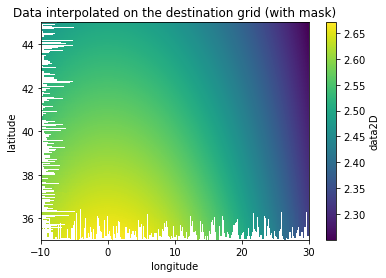

In [71]:
ds_regridded_read["data2D"].plot(x='lon',y='lat')
ax=plt.gca()
ax.set(title="Data interpolated on the destination grid (with mask)")

## Regridder construction with weights from ```regridder``` object + FIX10 - SUCCESS <a class ="anchor" id="ReUseWeightsFromRegridderObject"></a>

Options :```reuse_weights=True```, ```weights=regridder.weigths``` and ```filename=None```

In [72]:
print('We use the following regridder object')
print(reggrider.weights)

We use the following regridder object
<COO: shape=(334167, 334000), dtype=float64, nnz=1099428, sorted=True, duplicates=False>


In [73]:
reggrider_reuse_1 = xe.Regridder(ds_in,ds_out, method=method,extrap_method='nearest_s2d',reuse_weights=True,weights=reggrider.weights,filename=None)

Method IS = bilinear
NO BOUNDS NEEDED
@RegridderBase class instanciation : REUSING WEIGHTS
@RegridderBase class instanciation : convert WEIGHTS to sparse.COO matrix + try to wrap it into an xr.Dataset
@READ_WEIGHTS FUNCTION in smm.py
 => weights is already SPARSE.COO
    xarray.DataArray backed by the sparse.COO matrix of weights
    does not understand the sparse object and is hosting in turn
    the full matrix size => to avoid failure keep weights as a sparse.COO object
 @OUT READ_WEIGHTS FUNCTION in smm.py
@RegridderBase class instanciation : handle unmapped data due to grid masks
@add_nans_to_weights function in smm.py


## Regridding source data by re-using the weights from ```regridder``` object + FIX10 - SUCCESS

Options :```reuse_weights=True```, ```weights=regridder.weigths``` and ```filename=None```

In [74]:
ds_regridded_reuse_1  = ds_out.copy( deep=True )
ds_regridded_reuse_1["data2D"]=reggrider_reuse_1(ds_in["data2D"])

@Class Regridder.__call__ method : Memory Issue Handling
<COO: shape=(334167, 334000), dtype=float64, nnz=1099428, sorted=False, duplicates=True>
@Class Regridder.__call__ method : Memory Issue Handling
 weights has sparse.COO format
@@@ regrid_dataarray from sparse.coo weights matrix
@@@Numpy.ndarray : regrid_array


### Maps of regridded source data with fix FIX10 to issue9 - SUCCESS

  **```Regridder``` options ```reuse_weights=True```, ```weights=regridder.weigths``` and ```filename=None```**

**Regridded data**

[Text(0.5, 1.0, 'Data interpolated on the destination grid (with mask)')]

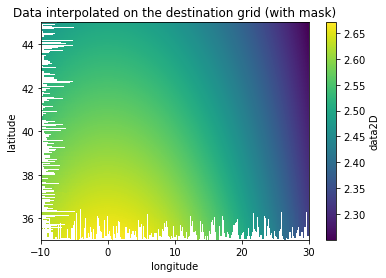

In [75]:
ds_regridded_reuse_1["data2D"].plot(x='lon',y='lat')
ax=plt.gca()
ax.set(title="Data interpolated on the destination grid (with mask)")

## Regridder construction with weights from ```regridder_reread``` object + FIX10 - SUCCESS <a class ="anchor" id="ReUseWeightsFromRegridderObjectReconstructedAfterRereadingWeights"></a>

Options : ```reuse_weights=True```, ```weights=regridder_reread.weigths``` and ```filename=None```

In [76]:
print('We use the following regridder object')
print(reggrider_reread.weights)

We use the following regridder object
<COO: shape=(334167, 334000), dtype=float64, nnz=1099428, sorted=True, duplicates=False>


In [77]:
reggrider_reuse_2 = xe.Regridder(ds_in,ds_out, method=method,extrap_method='nearest_s2d',reuse_weights=True,weights=reggrider_reread.weights, filename=None)

Method IS = bilinear
NO BOUNDS NEEDED
@RegridderBase class instanciation : REUSING WEIGHTS
@RegridderBase class instanciation : convert WEIGHTS to sparse.COO matrix + try to wrap it into an xr.Dataset
@READ_WEIGHTS FUNCTION in smm.py
 => weights is already SPARSE.COO
    xarray.DataArray backed by the sparse.COO matrix of weights
    does not understand the sparse object and is hosting in turn
    the full matrix size => to avoid failure keep weights as a sparse.COO object
 @OUT READ_WEIGHTS FUNCTION in smm.py
@RegridderBase class instanciation : handle unmapped data due to grid masks
@add_nans_to_weights function in smm.py


In [78]:
ds_regridded_reuse_2  = ds_out.copy( deep=True )
ds_regridded_reuse_2["data2D"]=reggrider_reuse_2(ds_in["data2D"])

@Class Regridder.__call__ method : Memory Issue Handling
<COO: shape=(334167, 334000), dtype=float64, nnz=1099428, sorted=False, duplicates=True>
@Class Regridder.__call__ method : Memory Issue Handling
 weights has sparse.COO format
@@@ regrid_dataarray from sparse.coo weights matrix
@@@Numpy.ndarray : regrid_array


### Maps of regridded source data with fix FIX10 to issue9 - SUCCESS

  **```Regridder``` options ```reuse_weights=True```, ```weights=regridder_reread.weigths``` and ```filename=None```**

**Regridded data**

[Text(0.5, 1.0, 'Data interpolated on the destination grid (with mask)')]

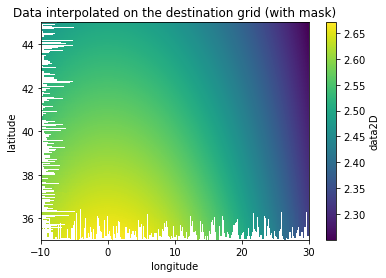

In [79]:
ds_regridded_reuse_2["data2D"].plot(x='lon',y='lat')
ax=plt.gca()
ax.set(title="Data interpolated on the destination grid (with mask)")

## Partial conclusion
<!-- Partial-conclusion -->

### Fix to the ```MemoryError``` exception with masked structured grids and bilinear regridding

The fix **FIX10** solves the ```MemoryError``` due to :

- the ```xarray``` pacakge limitations in handling sparse array object,

- the ```xesmf``` pacakage encapsulating the ```sparse.COO``` weight matrix into a ```xarray.DataArray``` structure.

The fix FIX10 includes fixes FIX1 and 2 which enables to handle source and destination grids with masked data (extrapolation).

Lest us now validate the fixes using other xesmf regridding options.


# Experiments with the other regridding methods to validate fix FIX10 applied to the xesmf conda-forge package in order to avoid the MemoryError <a class="anchor" id="ExpWithSeveralRegriddingMethods"></a>

In these experiments, we test fix FIX10 with the following regridding methods :

- **conservative,**
- **conservative_normed,**
- **patch...**

The other settings remain unchanged compare to the previous experiments.

## Conservative regridding method with FiX10<a class="anchor" id="ConservativeRegridding"></a>
   <!-- Conservative-regridding-method-with-FiX10 -->

In [80]:
del reggrider_reuse_1, reggrider_reuse_2, reggrider_reread

In [81]:
method='conservative'
extrap_method=None
reuse_weights=False
weights=None
print('- method={0}'.format(method))
print('- extrap_method={0}'.format(str(extrap_method)))
print('- reuse_weights={0}'.format(str(reuse_weights)))
print('- weights={0}'.format(str(weights)))

- method=conservative
- extrap_method=None
- reuse_weights=False
- weights=None


In [82]:
ny_src,nx_src = ds_in["data2D"].shape[0],ds_in["data2D"].shape[1]
ny_tgt_red,nx_tgt_red = ds_out['lon'].shape[0],ds_out['lon'].shape[1]
pattern='{0}_{1}x{2}_{3}x{4}'.format(
            method,
            ny_src,
            nx_src,
            ny_tgt_red,
            nx_tgt_red)
filout_wghts_='using_issue9_github_fix10_weights_'+pattern+'.nc'
filout_wghts=os.path.join(dirout,filout_wghts_)
print('Path to {0}'.format(filout_wghts))

Path to /tmpdir/p22007lb/Regridding_xesmf_tests/using_issue9_github_fix10_weights_conservative_334x1000_501x667.nc


In [83]:
regridder_conservative = xe.Regridder(ds_in,ds_out, method=method,extrap_method=extrap_method,weights=weights,filename=filout_wghts)

Method IS = conservative
NEED BOUNDS!!!!
@RegridderBase class instanciation : COMPUTE WEIGHTS
@RegridderBase class instanciation : convert WEIGHTS to sparse.COO matrix + try to wrap it into an xr.Dataset
@READ_WEIGHTS FUNCTION in smm.py
 => call _parse_coords_and_values SPARSE COORDS AND VALUE
<class 'dict'>
@_PARSE_COORDS_AND_VALUES FUNCTION in smm.py
@_parse_coords_and_values : FUNCTION ARG as dict
  => indata weights as dict : classical backend format for just calculated weights
     converting backend format to sparse.COO format
    xarray.DataArray backed by the sparse.COO matrix of weights
    does not understand the sparse object and is hosting in turn
    the full matrix size => to avoid failure keep weights as a sparse.COO object
 @OUT READ_WEIGHTS FUNCTION in smm.py
@RegridderBase class instanciation : handle unmapped data due to grid masks
@add_nans_to_weights function in smm.py
@to_netcdf : self.weights is a sps.COO matrix


In [84]:
ds_regridded_conservative  = ds_out.copy( deep=True )
ds_regridded_conservative["data2D"]=regridder_conservative(ds_in["data2D"])

@Class Regridder.__call__ method : Memory Issue Handling
<COO: shape=(334167, 334000), dtype=float64, nnz=1249687, sorted=False, duplicates=True>
@Class Regridder.__call__ method : Memory Issue Handling
 weights has sparse.COO format
@@@ regrid_dataarray from sparse.coo weights matrix
@@@Numpy.ndarray : regrid_array


In [85]:
print('Original  data with size of the source      grid is {0:d}x{1:d}'.format(ds_in["data2D"].shape[0],ds_in["data2D"].shape[1]))
print('Regridded data with size of the destination grid is {0:d}x{1:d}'.format(ds_regridded_conservative["data2D"].shape[0],ds_regridded_conservative["data2D"].shape[1]))

Original  data with size of the source      grid is 334x1000
Regridded data with size of the destination grid is 501x667


[Text(0.5, 1.0, 'Data interpolated on the destination grid (with mask) \n Conservative method')]

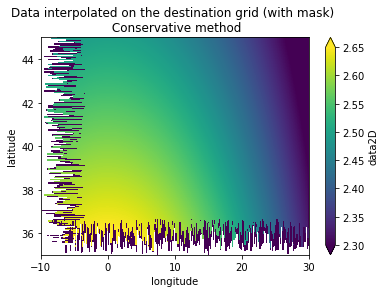

In [86]:
ds_regridded_conservative["data2D"].plot(x='lon',y='lat',vmin=2.30,vmax=2.65)
ax=plt.gca()
ax.set(title="Data interpolated on the destination grid (with mask) \n Conservative method")

[Text(0.5, 1.0, 'Data interpolated on the destination grid (with mask) \n Conservative method Mask issue')]

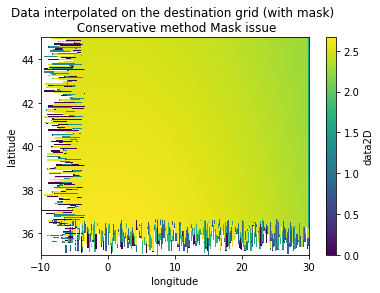

In [87]:
ds_regridded_conservative["data2D"].plot(x='lon',y='lat')
ax=plt.gca()
ax.set(title="Data interpolated on the destination grid (with mask) \n Conservative method Mask issue")

In [88]:
method='conservative'
extrap_method=None
reuse_weights=True
weights=None
print('- method={0}'.format(method))
print('- extrap_method={0}'.format(str(extrap_method)))
print('- reuse_weights={0}'.format(str(reuse_weights)))
print('- weights={0}'.format(str(weights)))
print('- filename={0}'.format(str(filout_wghts)))

- method=conservative
- extrap_method=None
- reuse_weights=True
- weights=None
- filename=/tmpdir/p22007lb/Regridding_xesmf_tests/using_issue9_github_fix10_weights_conservative_334x1000_501x667.nc


In [89]:
reggrider_reread = xe.Regridder(ds_in,ds_out, method=method,extrap_method=extrap_method,reuse_weights=reuse_weights,weights=weights,filename=filout_wghts)

Method IS = conservative
NEED BOUNDS!!!!
@RegridderBase class instanciation : REUSING WEIGHTS
@RegridderBase class instanciation : convert WEIGHTS to sparse.COO matrix + try to wrap it into an xr.Dataset
@READ_WEIGHTS FUNCTION in smm.py
 => call _parse_coords_and_values SPARSE COORDS AND VALUE
<class 'str'>
@_PARSE_COORDS_AND_VALUES FUNCTION in smm.py
@_parse_coords_and_values : FUNCTION ARG AS str, Path, xr.Dataset
 => indata weights as Path, str : reading indata into xr.Dataset as ds_w
['n_s']
 => expected fields col, row and s
    xarray.DataArray backed by the sparse.COO matrix of weights
    does not understand the sparse object and is hosting in turn
    the full matrix size => to avoid failure keep weights as a sparse.COO object
 @OUT READ_WEIGHTS FUNCTION in smm.py
@RegridderBase class instanciation : handle unmapped data due to grid masks
@add_nans_to_weights function in smm.py


#### ```Reggrider.weights```

In [90]:
reggrider_reread.weights

<COO: shape=(334167, 334000), dtype=float64, nnz=1249687, sorted=False, duplicates=True>

In [91]:
ds_regridded_read  = ds_out.copy( deep=True )
ds_regridded_read["data2D"]=reggrider_reread(ds_in["data2D"])

@Class Regridder.__call__ method : Memory Issue Handling
<COO: shape=(334167, 334000), dtype=float64, nnz=1249687, sorted=False, duplicates=True>
@Class Regridder.__call__ method : Memory Issue Handling
 weights has sparse.COO format
@@@ regrid_dataarray from sparse.coo weights matrix
@@@Numpy.ndarray : regrid_array


In [92]:
print('Original  data with size of the source      grid is {0:d}x{1:d}'.format(ds_in["data2D"].shape[0],ds_in["data2D"].shape[1]))
print('Regridded data with size of the destination grid is {0:d}x{1:d}'.format(ds_regridded_read["data2D"].shape[0],ds_regridded_read["data2D"].shape[1]))

Original  data with size of the source      grid is 334x1000
Regridded data with size of the destination grid is 501x667


[Text(0.5, 1.0, 'Data interpolated on the destination grid (with mask) \n Conservative method - re-use netCDF weights')]

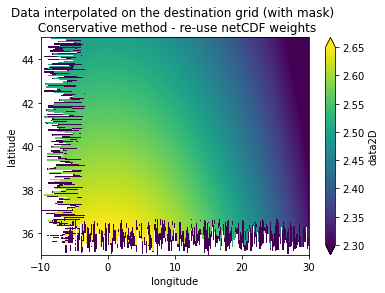

In [93]:
ds_regridded_read["data2D"].plot(x='lon',y='lat',vmin=2.30,vmax=2.65)
ax=plt.gca()
ax.set(title="Data interpolated on the destination grid (with mask) \n Conservative method - re-use netCDF weights")

In [94]:
method='conservative'
extrap_method=None
reuse_weights=True
weights=regridder_conservative.weights
filnam=None
print('- method={0}'.format(method))
print('- extrap_method={0}'.format(str(extrap_method)))
print('- reuse_weights={0}'.format(str(reuse_weights)))
print('- weights={0}'.format(str(weights)))
print('- filename={0}'.format(filnam))

- method=conservative
- extrap_method=None
- reuse_weights=True
- weights=<COO: shape=(334167, 334000), dtype=float64, nnz=1249687, sorted=True, duplicates=False>
- filename=None


In [95]:
reggrider_reuse_1 = xe.Regridder(ds_in,ds_out, method=method,extrap_method=extrap_method,reuse_weights=reuse_weights,weights=weights,filename=filnam)

Method IS = conservative
NEED BOUNDS!!!!
@RegridderBase class instanciation : REUSING WEIGHTS
@RegridderBase class instanciation : convert WEIGHTS to sparse.COO matrix + try to wrap it into an xr.Dataset
@READ_WEIGHTS FUNCTION in smm.py
 => weights is already SPARSE.COO
    xarray.DataArray backed by the sparse.COO matrix of weights
    does not understand the sparse object and is hosting in turn
    the full matrix size => to avoid failure keep weights as a sparse.COO object
 @OUT READ_WEIGHTS FUNCTION in smm.py
@RegridderBase class instanciation : handle unmapped data due to grid masks
@add_nans_to_weights function in smm.py


In [96]:
ds_regridded_reuse_1  = ds_out.copy( deep=True )
ds_regridded_reuse_1["data2D"]=reggrider_reuse_1(ds_in["data2D"])

@Class Regridder.__call__ method : Memory Issue Handling
<COO: shape=(334167, 334000), dtype=float64, nnz=1249687, sorted=False, duplicates=True>
@Class Regridder.__call__ method : Memory Issue Handling
 weights has sparse.COO format
@@@ regrid_dataarray from sparse.coo weights matrix
@@@Numpy.ndarray : regrid_array


[Text(0.5, 1.0, 'Data interpolated on the destination grid (with mask) \n Conservative method - re-use regridder weights object')]

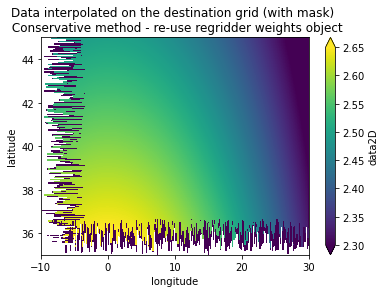

In [97]:
ds_regridded_reuse_1["data2D"].plot(x='lon',y='lat', vmin=2.30,vmax=2.65)
ax=plt.gca()
ax.set(title="Data interpolated on the destination grid (with mask) \n Conservative method - re-use regridder weights object")

## Conservative normed regridding method with FiX10<a class="anchor" id="ConservativeNormedRegridding"></a>
   <!-- Conservative-normed-regridding-method-with-FiX10 -->

In [98]:
del reggrider_reuse_1, reggrider_reread

In [99]:
method='conservative_normed'
extrap_method=None
reuse_weights=False
weights=None
print('- method={0}'.format(method))
print('- extrap_method={0}'.format(str(extrap_method)))
print('- reuse_weights={0}'.format(str(reuse_weights)))
print('- weights={0}'.format(str(weights)))

- method=conservative_normed
- extrap_method=None
- reuse_weights=False
- weights=None


In [100]:
ny_src,nx_src = ds_in["data2D"].shape[0],ds_in["data2D"].shape[1]
ny_tgt_red,nx_tgt_red = ds_out['lon'].shape[0],ds_out['lon'].shape[1]
pattern='{0}_{1}x{2}_{3}x{4}'.format(
            method,
            ny_src,
            nx_src,
            ny_tgt_red,
            nx_tgt_red)
filout_wghts_='using_issue9_github_fix10_weights_'+pattern+'.nc'
filout_wghts=os.path.join(dirout,filout_wghts_)
print('Path to {0}'.format(filout_wghts))

Path to /tmpdir/p22007lb/Regridding_xesmf_tests/using_issue9_github_fix10_weights_conservative_normed_334x1000_501x667.nc


In [101]:
regridder_conservative_normed = xe.Regridder(ds_in,ds_out, method=method,extrap_method=extrap_method,weights=weights,filename=filout_wghts)

Method IS = conservative_normed
NEED BOUNDS!!!!
@RegridderBase class instanciation : COMPUTE WEIGHTS
@RegridderBase class instanciation : convert WEIGHTS to sparse.COO matrix + try to wrap it into an xr.Dataset
@READ_WEIGHTS FUNCTION in smm.py
 => call _parse_coords_and_values SPARSE COORDS AND VALUE
<class 'dict'>
@_PARSE_COORDS_AND_VALUES FUNCTION in smm.py
@_parse_coords_and_values : FUNCTION ARG as dict
  => indata weights as dict : classical backend format for just calculated weights
     converting backend format to sparse.COO format
    xarray.DataArray backed by the sparse.COO matrix of weights
    does not understand the sparse object and is hosting in turn
    the full matrix size => to avoid failure keep weights as a sparse.COO object
 @OUT READ_WEIGHTS FUNCTION in smm.py
@RegridderBase class instanciation : handle unmapped data due to grid masks
@add_nans_to_weights function in smm.py
@to_netcdf : self.weights is a sps.COO matrix


In [102]:
ds_regridded_conservative_normed  = ds_out.copy( deep=True )
ds_regridded_conservative_normed["data2D"]=regridder_conservative_normed(ds_in["data2D"])

@Class Regridder.__call__ method : Memory Issue Handling
<COO: shape=(334167, 334000), dtype=float64, nnz=1249687, sorted=False, duplicates=True>
@Class Regridder.__call__ method : Memory Issue Handling
 weights has sparse.COO format
@@@ regrid_dataarray from sparse.coo weights matrix
@@@Numpy.ndarray : regrid_array


In [103]:
print('Original  data with size of the source      grid is {0:d}x{1:d}'.format(ds_in["data2D"].shape[0],ds_in["data2D"].shape[1]))
print('Regridded data with size of the destination grid is {0:d}x{1:d}'.format(ds_regridded_conservative_normed["data2D"].shape[0],ds_regridded_conservative_normed["data2D"].shape[1]))

Original  data with size of the source      grid is 334x1000
Regridded data with size of the destination grid is 501x667


[Text(0.5, 1.0, 'Data interpolated on the destination grid (with mask) \n Conservative normed method')]

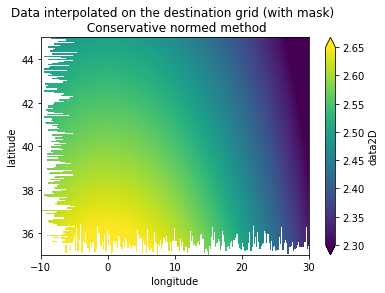

In [104]:
ds_regridded_conservative_normed["data2D"].plot(x='lon',y='lat', vmin=2.30, vmax=2.65)
ax=plt.gca()
ax.set(title="Data interpolated on the destination grid (with mask) \n Conservative normed method")

In [105]:
method='conservative_normed'
extrap_method=None
reuse_weights=True
weights=None
print('- method={0}'.format(method))
print('- extrap_method={0}'.format(str(extrap_method)))
print('- reuse_weights={0}'.format(str(reuse_weights)))
print('- weights={0}'.format(str(weights)))
print('- filename={0}'.format(str(filout_wghts)))

- method=conservative_normed
- extrap_method=None
- reuse_weights=True
- weights=None
- filename=/tmpdir/p22007lb/Regridding_xesmf_tests/using_issue9_github_fix10_weights_conservative_normed_334x1000_501x667.nc


In [106]:
reggrider_reread = xe.Regridder(ds_in,ds_out, method=method,extrap_method=extrap_method,reuse_weights=reuse_weights,weights=weights,filename=filout_wghts)

Method IS = conservative_normed
NEED BOUNDS!!!!
@RegridderBase class instanciation : REUSING WEIGHTS
@RegridderBase class instanciation : convert WEIGHTS to sparse.COO matrix + try to wrap it into an xr.Dataset
@READ_WEIGHTS FUNCTION in smm.py
 => call _parse_coords_and_values SPARSE COORDS AND VALUE
<class 'str'>
@_PARSE_COORDS_AND_VALUES FUNCTION in smm.py
@_parse_coords_and_values : FUNCTION ARG AS str, Path, xr.Dataset
 => indata weights as Path, str : reading indata into xr.Dataset as ds_w
['n_s']
 => expected fields col, row and s
    xarray.DataArray backed by the sparse.COO matrix of weights
    does not understand the sparse object and is hosting in turn
    the full matrix size => to avoid failure keep weights as a sparse.COO object
 @OUT READ_WEIGHTS FUNCTION in smm.py
@RegridderBase class instanciation : handle unmapped data due to grid masks
@add_nans_to_weights function in smm.py


#### ```Reggrider.weights```

In [107]:
reggrider_reread.weights

<COO: shape=(334167, 334000), dtype=float64, nnz=1249687, sorted=False, duplicates=True>

In [108]:
ds_regridded_read  = ds_out.copy( deep=True )
ds_regridded_read["data2D"]=reggrider_reread(ds_in["data2D"])

@Class Regridder.__call__ method : Memory Issue Handling
<COO: shape=(334167, 334000), dtype=float64, nnz=1249687, sorted=False, duplicates=True>
@Class Regridder.__call__ method : Memory Issue Handling
 weights has sparse.COO format
@@@ regrid_dataarray from sparse.coo weights matrix
@@@Numpy.ndarray : regrid_array


In [109]:
print('Original  data with size of the source      grid is {0:d}x{1:d}'.format(ds_in["data2D"].shape[0],ds_in["data2D"].shape[1]))
print('Regridded data with size of the destination grid is {0:d}x{1:d}'.format(ds_regridded_read["data2D"].shape[0],ds_regridded_read["data2D"].shape[1]))

Original  data with size of the source      grid is 334x1000
Regridded data with size of the destination grid is 501x667


[Text(0.5, 1.0, 'Data interpolated on the destination grid (with mask) \n Conservative normed method - re-use netCDF weights')]

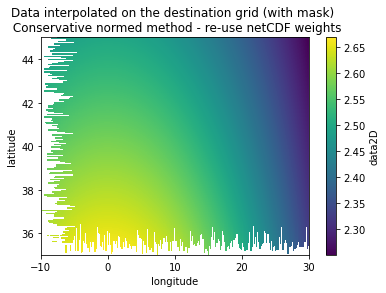

In [110]:
ds_regridded_read["data2D"].plot(x='lon',y='lat')
ax=plt.gca()
ax.set(title="Data interpolated on the destination grid (with mask) \n Conservative normed method - re-use netCDF weights")

In [111]:
method='conservative_normed'
extrap_method=None
reuse_weights=True
weights=regridder_conservative_normed.weights
filnam=None
print('- method={0}'.format(method))
print('- extrap_method={0}'.format(str(extrap_method)))
print('- reuse_weights={0}'.format(str(reuse_weights)))
print('- weights={0}'.format(str(weights)))
print('- filename={0}'.format(filnam))

- method=conservative_normed
- extrap_method=None
- reuse_weights=True
- weights=<COO: shape=(334167, 334000), dtype=float64, nnz=1249687, sorted=True, duplicates=False>
- filename=None


In [112]:
reggrider_reuse_1 = xe.Regridder(ds_in,ds_out, method=method,extrap_method=extrap_method,reuse_weights=reuse_weights,weights=weights,filename=filnam)

Method IS = conservative_normed
NEED BOUNDS!!!!
@RegridderBase class instanciation : REUSING WEIGHTS
@RegridderBase class instanciation : convert WEIGHTS to sparse.COO matrix + try to wrap it into an xr.Dataset
@READ_WEIGHTS FUNCTION in smm.py
 => weights is already SPARSE.COO
    xarray.DataArray backed by the sparse.COO matrix of weights
    does not understand the sparse object and is hosting in turn
    the full matrix size => to avoid failure keep weights as a sparse.COO object
 @OUT READ_WEIGHTS FUNCTION in smm.py
@RegridderBase class instanciation : handle unmapped data due to grid masks
@add_nans_to_weights function in smm.py


In [113]:
ds_regridded_reuse_1  = ds_out.copy( deep=True )
ds_regridded_reuse_1["data2D"]=reggrider_reuse_1(ds_in["data2D"])

@Class Regridder.__call__ method : Memory Issue Handling
<COO: shape=(334167, 334000), dtype=float64, nnz=1249687, sorted=False, duplicates=True>
@Class Regridder.__call__ method : Memory Issue Handling
 weights has sparse.COO format
@@@ regrid_dataarray from sparse.coo weights matrix
@@@Numpy.ndarray : regrid_array


[Text(0.5, 1.0, 'Data interpolated on the destination grid (with mask) \n Conservative normed method - re-use regridder weights object')]

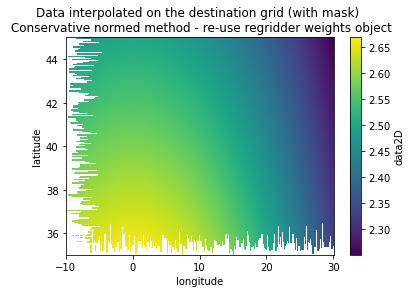

In [114]:
ds_regridded_reuse_1["data2D"].plot(x='lon',y='lat')
ax=plt.gca()
ax.set(title="Data interpolated on the destination grid (with mask) \n Conservative normed method - re-use regridder weights object")

## Patch regridding method with FiX10<a class="anchor" id="PatchRegridding"></a>
   <!-- Patch-regridding-method-with-FiX10 -->

In [115]:
del reggrider_reuse_1, reggrider_reread

In [116]:
del ds_regridded_reuse_1, ds_regridded_read

In [117]:
method='patch'
extrap_method=None
reuse_weights=False
weights=None
print('- method={0}'.format(method))
print('- extrap_method={0}'.format(str(extrap_method)))
print('- reuse_weights={0}'.format(str(reuse_weights)))
print('- weights={0}'.format(str(weights)))

- method=patch
- extrap_method=None
- reuse_weights=False
- weights=None


In [118]:
ny_src,nx_src = ds_in["data2D"].shape[0],ds_in["data2D"].shape[1]
ny_tgt_red,nx_tgt_red = ds_out['lon'].shape[0],ds_out['lon'].shape[1]
pattern='{0}_{1}x{2}_{3}x{4}'.format(
            method,
            ny_src,
            nx_src,
            ny_tgt_red,
            nx_tgt_red)
filout_wghts_='using_issue9_github_fix10_weights_'+pattern+'.nc'
filout_wghts=os.path.join(dirout,filout_wghts_)
print('Path to {0}'.format(filout_wghts))

Path to /tmpdir/p22007lb/Regridding_xesmf_tests/using_issue9_github_fix10_weights_patch_334x1000_501x667.nc


In [119]:
regridder_patch = xe.Regridder(ds_in,ds_out, method=method,extrap_method=extrap_method,weights=weights,filename=filout_wghts)

Method IS = patch
NO BOUNDS NEEDED
@RegridderBase class instanciation : COMPUTE WEIGHTS
@RegridderBase class instanciation : convert WEIGHTS to sparse.COO matrix + try to wrap it into an xr.Dataset
@READ_WEIGHTS FUNCTION in smm.py
 => call _parse_coords_and_values SPARSE COORDS AND VALUE
<class 'dict'>
@_PARSE_COORDS_AND_VALUES FUNCTION in smm.py
@_parse_coords_and_values : FUNCTION ARG as dict
  => indata weights as dict : classical backend format for just calculated weights
     converting backend format to sparse.COO format
    xarray.DataArray backed by the sparse.COO matrix of weights
    does not understand the sparse object and is hosting in turn
    the full matrix size => to avoid failure keep weights as a sparse.COO object
 @OUT READ_WEIGHTS FUNCTION in smm.py
@RegridderBase class instanciation : handle unmapped data due to grid masks
@add_nans_to_weights function in smm.py
@to_netcdf : self.weights is a sps.COO matrix


In [120]:
ds_regridded_patch  = ds_out.copy( deep=True )
ds_regridded_patch["data2D"]=regridder_patch(ds_in["data2D"])

@Class Regridder.__call__ method : Memory Issue Handling
<COO: shape=(334167, 334000), dtype=float64, nnz=4157968, sorted=False, duplicates=True>
@Class Regridder.__call__ method : Memory Issue Handling
 weights has sparse.COO format
@@@ regrid_dataarray from sparse.coo weights matrix
@@@Numpy.ndarray : regrid_array


In [121]:
print('Original  data with size of the source      grid is {0:d}x{1:d}'.format(ds_in["data2D"].shape[0],ds_in["data2D"].shape[1]))
print('Regridded data with size of the destination grid is {0:d}x{1:d}'.format(ds_regridded_patch["data2D"].shape[0],ds_regridded_patch["data2D"].shape[1]))

Original  data with size of the source      grid is 334x1000
Regridded data with size of the destination grid is 501x667


[Text(0.5, 1.0, 'Data interpolated on the destination grid (with mask) \n Patch method')]

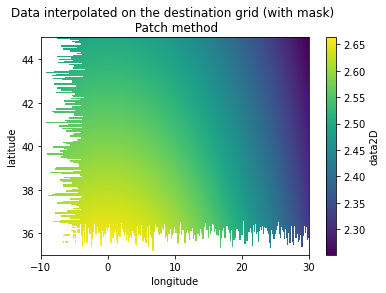

In [122]:
ds_regridded_patch["data2D"].plot(x='lon',y='lat')
ax=plt.gca()
ax.set(title="Data interpolated on the destination grid (with mask) \n Patch method")

In [123]:
method='patch'
extrap_method=None
reuse_weights=True
weights=None
print('- method={0}'.format(method))
print('- extrap_method={0}'.format(str(extrap_method)))
print('- reuse_weights={0}'.format(str(reuse_weights)))
print('- weights={0}'.format(str(weights)))
print('- filename={0}'.format(str(filout_wghts)))

- method=patch
- extrap_method=None
- reuse_weights=True
- weights=None
- filename=/tmpdir/p22007lb/Regridding_xesmf_tests/using_issue9_github_fix10_weights_patch_334x1000_501x667.nc


In [124]:
reggrider_reread = xe.Regridder(ds_in,ds_out, method=method,extrap_method=extrap_method,reuse_weights=reuse_weights,weights=weights,filename=filout_wghts)

Method IS = patch
NO BOUNDS NEEDED
@RegridderBase class instanciation : REUSING WEIGHTS
@RegridderBase class instanciation : convert WEIGHTS to sparse.COO matrix + try to wrap it into an xr.Dataset
@READ_WEIGHTS FUNCTION in smm.py
 => call _parse_coords_and_values SPARSE COORDS AND VALUE
<class 'str'>
@_PARSE_COORDS_AND_VALUES FUNCTION in smm.py
@_parse_coords_and_values : FUNCTION ARG AS str, Path, xr.Dataset
 => indata weights as Path, str : reading indata into xr.Dataset as ds_w
['n_s']
 => expected fields col, row and s
    xarray.DataArray backed by the sparse.COO matrix of weights
    does not understand the sparse object and is hosting in turn
    the full matrix size => to avoid failure keep weights as a sparse.COO object
 @OUT READ_WEIGHTS FUNCTION in smm.py
@RegridderBase class instanciation : handle unmapped data due to grid masks
@add_nans_to_weights function in smm.py


#### ```Reggrider.weights```

In [125]:
reggrider_reread.weights

<COO: shape=(334167, 334000), dtype=float64, nnz=4157968, sorted=False, duplicates=True>

In [126]:
ds_regridded_read  = ds_out.copy( deep=True )
ds_regridded_read["data2D"]=reggrider_reread(ds_in["data2D"])

@Class Regridder.__call__ method : Memory Issue Handling
<COO: shape=(334167, 334000), dtype=float64, nnz=4157968, sorted=False, duplicates=True>
@Class Regridder.__call__ method : Memory Issue Handling
 weights has sparse.COO format
@@@ regrid_dataarray from sparse.coo weights matrix
@@@Numpy.ndarray : regrid_array


In [127]:
print('Original  data with size of the source      grid is {0:d}x{1:d}'.format(ds_in["data2D"].shape[0],ds_in["data2D"].shape[1]))
print('Regridded data with size of the destination grid is {0:d}x{1:d}'.format(ds_regridded_read["data2D"].shape[0],ds_regridded_read["data2D"].shape[1]))

Original  data with size of the source      grid is 334x1000
Regridded data with size of the destination grid is 501x667


[Text(0.5, 1.0, 'Data interpolated on the destination grid (with mask) \n Patch method - re-use netCDF weights')]

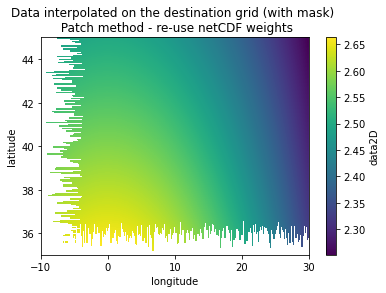

In [128]:
ds_regridded_read["data2D"].plot(x='lon',y='lat')
ax=plt.gca()
ax.set(title="Data interpolated on the destination grid (with mask) \n Patch method - re-use netCDF weights")

In [129]:
method='patch'
extrap_method=None
reuse_weights=True
weights=regridder_patch.weights
filnam=None
print('- method={0}'.format(method))
print('- extrap_method={0}'.format(str(extrap_method)))
print('- reuse_weights={0}'.format(str(reuse_weights)))
print('- weights={0}'.format(str(weights)))
print('- filename={0}'.format(filnam))

- method=patch
- extrap_method=None
- reuse_weights=True
- weights=<COO: shape=(334167, 334000), dtype=float64, nnz=4157968, sorted=True, duplicates=False>
- filename=None


In [130]:
reggrider_reuse_1 = xe.Regridder(ds_in,ds_out, method=method,extrap_method=extrap_method,reuse_weights=reuse_weights,weights=weights,filename=filnam)

Method IS = patch
NO BOUNDS NEEDED
@RegridderBase class instanciation : REUSING WEIGHTS
@RegridderBase class instanciation : convert WEIGHTS to sparse.COO matrix + try to wrap it into an xr.Dataset
@READ_WEIGHTS FUNCTION in smm.py
 => weights is already SPARSE.COO
    xarray.DataArray backed by the sparse.COO matrix of weights
    does not understand the sparse object and is hosting in turn
    the full matrix size => to avoid failure keep weights as a sparse.COO object
 @OUT READ_WEIGHTS FUNCTION in smm.py
@RegridderBase class instanciation : handle unmapped data due to grid masks
@add_nans_to_weights function in smm.py


In [131]:
ds_regridded_reuse_1  = ds_out.copy( deep=True )
ds_regridded_reuse_1["data2D"]=reggrider_reuse_1(ds_in["data2D"])

@Class Regridder.__call__ method : Memory Issue Handling
<COO: shape=(334167, 334000), dtype=float64, nnz=4157968, sorted=False, duplicates=True>
@Class Regridder.__call__ method : Memory Issue Handling
 weights has sparse.COO format
@@@ regrid_dataarray from sparse.coo weights matrix
@@@Numpy.ndarray : regrid_array


[Text(0.5, 1.0, 'Data interpolated on the destination grid (with mask) \n Patch method - re-use regridder weights object')]

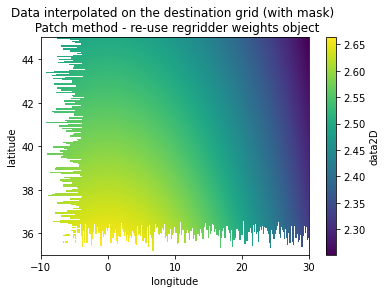

In [132]:
ds_regridded_reuse_1["data2D"].plot(x='lon',y='lat')
ax=plt.gca()
ax.set(title="Data interpolated on the destination grid (with mask) \n Patch method - re-use regridder weights object")

# Conclusion 
<a class="anchor" id="Conclusion"></a>

## Issue9 : tests and fix

Issue *Issue9* is encountered with the package xesmf while encapsulating the sparse matrix of regridding weights under an ```xarray.DataArray``` structure. This can cause **```MemoryError``` failures** and/or result in the **use of an unecessary large amount of Memory**. This notebook investigate it in-depths. 

In this document, we **reproduce the MemoryError issue** with [synthetic grids](https://github.com/pangeo-data/xESMF/blob/master/doc/notebooks/Backend.ipynb?). We propose a basic **fixe** consisting in maintaining the regridding **weights under their sparse representation** as a ```sparse.COO``` matrix. We **conduct tests with several regridding methods** and context, and the fix pass the tests **with Success**. The fix was tested against synthetic and real data.

A **dedicated branch under the github** has been set up within the following [**forked repository**](https://github.com/lemieuxbenedicte/xESMF?) where we **propose fixes and tests** presented in this jupyter-notebook. Please follow the links :
 - to [github branch related to issue9](https://github.com/lemieuxbenedicte/xESMF/tree/master/xesmf/xesmf_fix10?),
 - and to the [github jupyter-notebooks](https://github.com/lemieuxbenedicte/xESMF/tree/master/doc/notebooks/Large_size_problems_Structured_grids_with_mask_FIX10_Issue9_with_xarray_DataArray_backed_by_sparse_COO.ipynb?)

The pitfall is related related to the handling of the regridding weights as a ```sparse.COO``` array and/or an ```xarray.DataArray``` backed by a ```sparse.COO``` array. The 2D sparse of regridding weights (mapping the source grid data to the destination grid) s a sparse matrix represented under ```sparse.COO``` format and package. ```xesmf``` encapsulates the matrix of weights into an ```xarray.DataArray``` structure. However, **```xarray``` package is not currently able to properly encapsulate sparse array object**, such as **```sparse.COO```**. ```xarray``` **fails interpreting the sparse object hidden behind the ```numpy.ndarray``` type** and **reserves Memory for the full size array instead**. This can cause **```MemoryError``` failures** and/or result in the **use of an unecessary large amount of Memory**.

This document and experiments are twined with another jupyter-notebook intended to describe and propose fixes to
a connected issue (a simple bug) also related to the handling of the regridding weights as a ```sparse.COO``` array and/or an ```xarray.DataArray``` backed by a ```sparse.COO``` array (issues when handling grids with masked data and the writing of the interpolation weights to a netCDF file). This notebook is available [here](Small_size_problems_Structured_grids_with_mask_Issues_1_and_2_with_xarray_DataArray_backed_by_sparse_COO.ipynb?) or on the [github forked repository](https://github.com/lemieuxbenedicte/xESMF/tree/master/doc/notebooks/Small_size_problems_Structured_grids_with_mask_Issues_1_and_2_with_xarray_DataArray_backed_by_sparse_COO.ipynb?/-).

### Further considerations related to fix FIX10 to issue9

I really like the idea of having a wrapper to esmpy/ESMF which enables the use of xarray objects keeping under the hood numpy, scipy...etc. Sharing my tests and solutions might eventually be useful for other users, or useful to trigger a discussion with developpers, to see with them what would be the other ways to overcome these issues.

I am aware that ```xesmf``` is meant to be a wrapper of esmpy/ESMF providing facilities to use the full power of ```xarray``` (as well as ```dask```) objects and methods. In this respect, it makes an extensive use of ```xarray.DataArray``` or ```xarray.Dataset``` to encapsulate either numpy.ndarray or dask.Array (e.g., source and destination grid data) or ```sparse.COO``` objects (regridding weights). It is possible that the fix proposed here does not fit this phylosophy <a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1). Also other tests might be necessary to validate the approache against other pieces of script/code of the xesmf/esmpy/ESMF tool I am not aware of. Maybe some developments might come into play latter on <a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2).
 
<a name="cite_note-1"></a>1. [^](#cite_ref-1) Could this document highlight some possible conflicting requirements for the ```xesmf``` packages : (i) being efficient in terms of system ressources, and (ii) on the other hand being a powerful and user-friendly tool handling high-level python package  such as ```xarray``` (and ```dask```).

<a name="cite_note-2"></a>2. [^](#cite_ref-2) xesmf with updated dependencies and new releases for the ```xarray```, ```sparse```,...etc. Is-it also possible that ```xarray``` upgrades to correctly handle the sparse object ?